In [1]:
using StaticArrays, SeeToDee
using ControlSystemIdentification, ControlSystemsBase
using ControlSystemsBase.DemoSystems: resonant
using LowLevelParticleFilters
using LeastSquaresOptim
using Random, Plots, LinearAlgebra

In [2]:

function quadtank(h, u, p, t)
    k1, k2, g = p[1], p[2], 9.81
    A1 = A3 = A2 = A4 = p[3]
    a1 = a3 = a2 = a4 = 0.03
    γ1 = γ2 = p[4]

    ssqrt(x) = √(max(x, zero(x)) + 1e-3) # For numerical robustness at x = 0

    SA[
        -a1/A1 * ssqrt(2g*h[1]) + a3/A1*ssqrt(2g*h[3]) +     γ1*k1/A1 * u[1]
        -a2/A2 * ssqrt(2g*h[2]) + a4/A2*ssqrt(2g*h[4]) +     γ2*k2/A2 * u[2]
        -a3/A3*ssqrt(2g*h[3])                          + (1-γ2)*k2/A3 * u[2]
        -a4/A4*ssqrt(2g*h[4])                          + (1-γ1)*k1/A4 * u[1]
    ]
end

quadtank (generic function with 1 method)

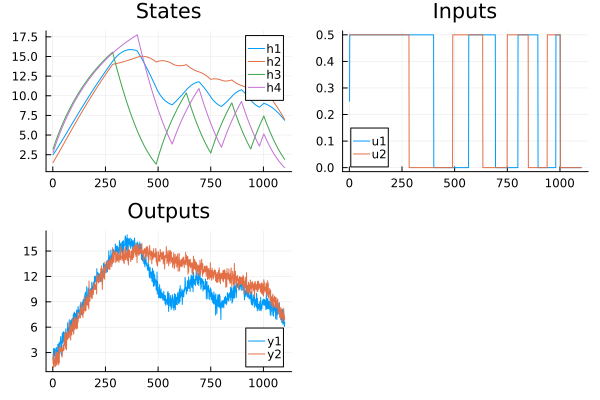

In [3]:
measurement(x,u,p,t) = SA[x[1], x[2]]

Ts = 1.0
discrete_dynamics = SeeToDee.Rk4(quadtank, Ts, supersample=2)

nx = 4
ny = 2
nu = 2
p_true = [1.6, 1.6, 4.9, 0.2]


# Generate some data from the system
Random.seed!(1)
Tperiod = 200
t = 0:Ts:1000
u1 = vcat.(0.25 .* sign.(sin.(2pi/Tperiod .* (t ./ 40).^2)) .+ 0.25)
u2 = vcat.(0.25 .* sign.(sin.(2pi/Tperiod .* (t ./ 40).^2 .+ pi/2)) .+ 0.25)
u  = vcat.(u1,u2)
u = [u; 0 .* u[1:100]]
x0 = [2.5, 1.5, 3.2, 2.8]
x = LowLevelParticleFilters.rollout(discrete_dynamics, x0, u, p_true)[1:end-1]
y = measurement.(x, u, 0, 0)
y = [y .+ 0.5randn(ny) for y in y] # Add some measurement noise
Y = reduce(hcat, y) # Go from vector of vectors to a matrix
U = reduce(hcat, u) # Go from vector of vectors to a matrix
_plot = plot(
    plot(reduce(hcat, x)', title="States", lab=["h1" "h2" "h3" "h4"]),
    plot(U', title="Inputs", lab=["u1" "u2"]),
    plot(Y', title="Outputs", lab=["y1" "y2"]),
)

In [4]:
d = iddata(Y, U, Ts)
x0_guess = [2.5, 1.5, 1, 2] # Guess for the initial condition
p_guess = [1.4, 1.4, 5.1, 0.25] # Initial guess for the parameters

R1 = Diagonal([0.1, 0.1, 0.1, 0.1])
R2 = 100*Diagonal(0.5^2 * ones(ny))

model = ControlSystemIdentification.nonlinear_pem(d, discrete_dynamics, measurement, p_guess, x0_guess, R1, R2, nu)

     0     6.442971e+02              Inf


     1     5.930295e+02     1.210162e+02
     2     5.926074e+02     8.209561e+00


     3     5.926061e+02     1.075791e+00
     4     5.926061e+02     1.141612e-01
     5     5.926061e+02     4.193833e-02


NonlinearPredictionErrorModel
  p: [1.6130595662288059, 1.5994574203026606, 4.886961965817006, 0.20432997287915144]
  x0: [2.558506451200764, 1.6722780052530581, 2.878022716639346, 2.0924081421739773]
  Ts: 1.0
  ny = 2, nu = 2, nx = 4


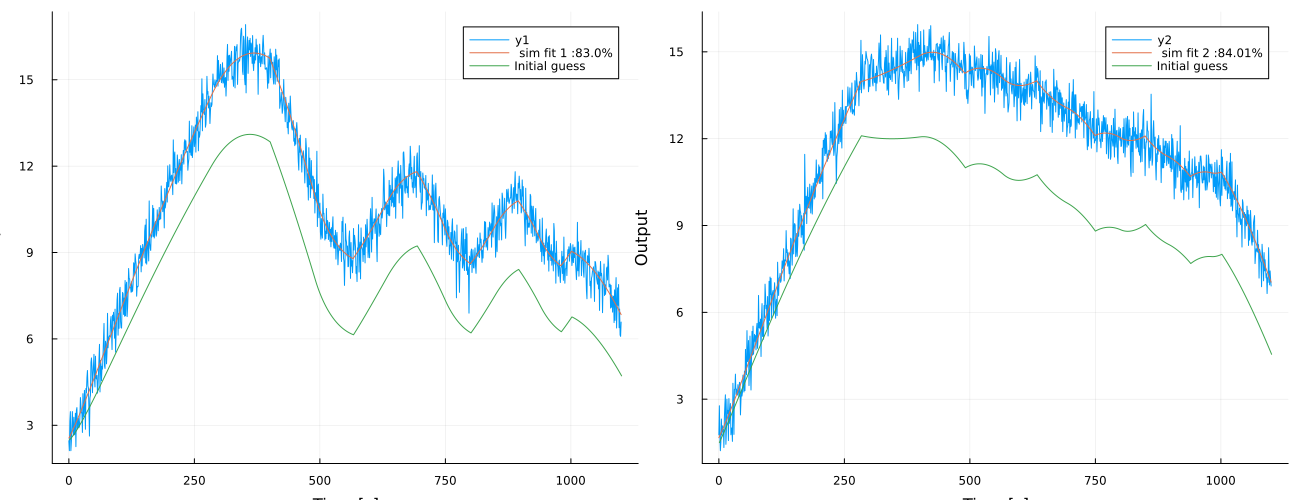

In [5]:
simplot(model, d, layout=2, size=(1300, 500))

x_guess = LowLevelParticleFilters.rollout(discrete_dynamics, x0_guess, u, p_guess)[1:end-1]
y_guess = measurement.(x_guess, u, 0, 0)
plot!(reduce(hcat, y_guess)', lab="Initial guess")